<font size="+3" color=red><b> <u>Module 5:</u></b></font>

<font size="+3"><b> <u>**Projet 1:**  Détection de la pneumonie à l'aide d'un réseau de neurones convolutif (CNN) </u></b></font>



 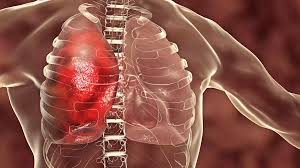

# Objectif

L'objectif de cette application est d'implémenter un algorithme d'apprentissage profond ResNet pour détecter la présence d'une pneumonie dans des images radiographiques.


<a id="4"></a>
<font color="blue" size=+2.5><b>Installation des librairies</b></font>
* Numpy
* Pandas
* Matplotlib
* Fastai

<a id="5"></a>
<font color="blue" size=+2.5><b>Importation des librairies</b></font>

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from fastai.vision import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id="6"></a>
<font color="blue" size=+2.5><b>Base de données</b></font>

**Chest-xray pneumonia** est la base de données publique utilisée pour entraîner notre modèle d'apprentissage profond.
Cette base de données contient des images de radiographies thoraciques (Chest X-Ray) qui sont étiquetées de la manière suivante : **pneumonia** pour les cas de pneumonie et "**normal**" pour les cas sans maladie. 
Elle est divisée en trois dossiers : train (5216 images: 1341 normal et 3875 pneumonia) pour l'entraînement, validation (16 images: 8 normal et 8 pneumonia) pour la validation, et test (624 images: 234 normal et 390 pneumonia) pour tester le modèle.
lien: https://doi.org/10.17632/rscbjbr9sj.3


**Répertoire de stockage**

In [6]:
x  = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
path = Path(x)
path.ls()

[PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'),
 PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store'),
 PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'),
 PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train')]

<a id="7"></a>
<font color="blue" size=+2.5><b>Chargement des données</b></font>
<br/>

**ImageDataBunch.from_folder** : Cette méthode est utilisée pour charger des images à partir de sous-dossiers dans un répertoire.

La base de données est stockée sous forme de fichiers .jpg dans deux dossiers distincts, chaque dossier portant le nom de la classe des images qu'il contient. Nous utilisons la fonction ImageDataBunch.from_folder() pour charger les images et leur attribuer automatiquement des étiquettes en fonction du nom du dossier dans lequel elles se trouvent.

* la taille de l'image utilisée  est de 224 x 224





In [7]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train='train', valid='val',
                                   ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)

La commande **data.show_batch(rows=3, figsize=(7,6), recompute_scale_factor=True)** est utilisée pour afficher un échantillon d'images de votre ensemble de données

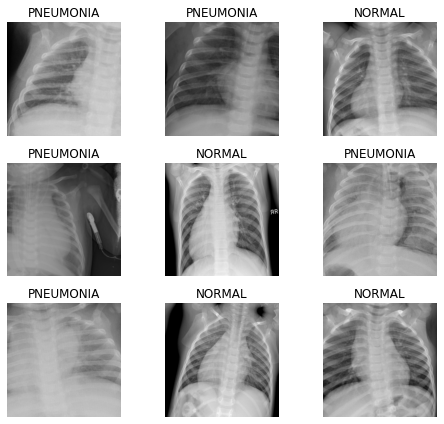

In [8]:
data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)


In [9]:
# Load labeled test data
test_data = (ImageList.from_folder(path/'test')
             .split_none()
             .label_from_folder()
             .transform(get_transforms(), size=224)
             .databunch(bs=64).normalize(imagenet_stats))

* **data.classes** - Combien y a-t-il de classes dans notre ensemble de données ?
* **len(data.train_ds)** - Quelle est la taille de notre ensemble de données d'apprentissage ?
* **len(data.valid_ds)** - Quelle est la taille de notre ensemble de données de validation ?

In [10]:
print("Nombre de classes:", len(data.classes),";", data.classes)
print("Nombre d'image d'entrainement:",len(data.train_ds))
print("Nombre d'image de validation:",len(data.valid_ds))


Nombre de classes: 2 ; ['NORMAL', 'PNEUMONIA']
Nombre d'image d'entrainement: 5216
Nombre d'image de validation: 16


In [11]:
data

ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray;

Valid: LabelList (16 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray;

Test: None

In [12]:
test_data

ImageDataBunch;

Train: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test;

Test: None

<a id="10"></a>
<font color="blue" size=+2.5><b>Modèle de deep learning</b></font>
<br/>
Nous utilisons maintenant un modèle de réseau neuronal convolutif  **ResNet50**.
* ResNet50 est un modèle de réseau de neurones convolutif profond qui fait partie de la famille des réseaux résiduels (ResNet). Composé de 50 couches, il utilise des blocs résiduels pour permettre l'apprentissage efficace dans des réseaux très profonds en évitant les problèmes de dégradation des gradients. Ces blocs résiduels introduisent des connexions de saut qui ajoutent l'entrée d'une couche à sa sortie, facilitant ainsi l'entraînement. Son architecture comprend 49 couches convolutives, une couche de max pooling, et se termine par une couche entièrement connectée pour la classification finale. ResNet50 est largement utilisé pour des tâches de classification d'images et de reconnaissance d'objets, offrant un excellent équilibre entre précision et complexité computationnelle.


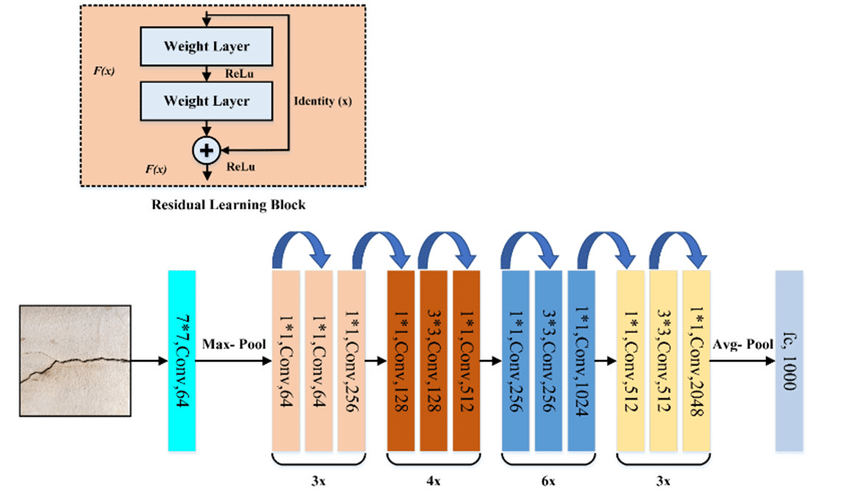

In [13]:
# Télécharger le modèle ResNet50 pré-entraîné
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [14]:
# Remplacer la dernière couche entièrement connectée pour s'adapter à notre nombre de classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, data.c)  # data.c correspond au nombre de classes

**# Définir la fonction de perte (CrossEntropyLoss) et l'optimiseur (Adam)**
> La fonction de perte et l'optimiseur sont deux éléments cruciaux dans l'entraînement d'un modèle de machine learning. 

> La fonction de perte CrossEntropyLoss est utilisée pour évaluer l'écart entre les prédictions du modèle et les étiquettes réelles des données d'entraînement. Elle est particulièrement adaptée aux tâches de classification, car elle mesure la différence entre la distribution de probabilité prédite par le modèle et la distribution réelle (représentée par les étiquettes). Une perte élevée indique une grande différence entre les prédictions et la réalité, ce qui signifie que le modèle doit encore apprendre pour améliorer ses prédictions. 

> Pour minimiser cette perte, on utilise un optimiseur, tel que l'optimiseur Adam (Adaptive Moment Estimation), qui ajuste les poids du modèle de manière efficace à chaque itération de l'entraînement.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Déplacer le modèle sur le GPU s'il est disponible, sinon sur le CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

<a id="7"></a>
<font color="blue" size=+2.5><b>Entrainement de modèle :</b></font>
<br/>

> Notre modèle est entraîné sur 50 époques (epochs), ce qui signifie qu'il passe 50 fois sur l'ensemble de données d'entraînement pour ajuster ses paramètres internes et améliorer ses prédictions. À chaque époque, le modèle apprend à mieux comprendre les relations dans les données, en ajustant progressivement ses poids et ses biais pour minimiser l'erreur de prédiction. Ce processus permet au modèle de devenir de plus en plus précis, tout en s'assurant qu'il généralise bien aux nouvelles données.


In [18]:
# Spécifier le chemin du fichier texte pour enregistrer les informations d'entraînement
log_file_path = "log_chargement_donnees.txt"

# Début de l'entraînement du modèle
num_epochs = 50  # Nombre d'époques d'entraînement

# Ouvrir le fichier texte en mode écriture pour ajouter les informations d'entraînement
with open(log_file_path, "w") as log_file:
    for epoch in range(num_epochs):
        model.train()  # Mettre le modèle en mode entraînement
        running_loss = 0.0
        running_corrects = 0

        # Boucle sur les données d'entraînement
        for i, (inputs, labels) in enumerate(data.train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Remise à zéro des gradients
            optimizer.zero_grad()

            # Avant et arrière-propagation
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistiques d'entraînement
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Afficher les détails de chaque batch d'entraînement
            batch_loss = loss.item()
            batch_acc = torch.sum(preds == labels.data).double() / inputs.size(0)
            print(f'Batch {i+1}: Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}')

            # Écrire les détails de chaque batch dans le fichier texte
            log_file.write(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1} - Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}\n')

        # Calcul de la perte et de l'exactitude pour l'époque
        epoch_loss = running_loss / len(data.train_ds)
        epoch_acc = running_corrects.double() / len(data.train_ds)

        # Afficher les résultats après chaque époque
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Écrire les résultats de l'époque dans le fichier texte
        log_file.write(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}\n')


Batch 1: Loss: 0.6391, Accuracy: 0.6406
Batch 2: Loss: 0.2382, Accuracy: 0.8750
Batch 3: Loss: 0.4171, Accuracy: 0.8906
Batch 4: Loss: 0.5164, Accuracy: 0.8438
Batch 5: Loss: 0.2872, Accuracy: 0.8906
Batch 6: Loss: 0.1717, Accuracy: 0.9375
Batch 7: Loss: 0.1767, Accuracy: 0.9062
Batch 8: Loss: 0.1788, Accuracy: 0.9531
Batch 9: Loss: 0.2774, Accuracy: 0.8906
Batch 10: Loss: 0.2372, Accuracy: 0.9062
Batch 11: Loss: 0.1946, Accuracy: 0.9219
Batch 12: Loss: 0.2900, Accuracy: 0.9219
Batch 13: Loss: 0.2389, Accuracy: 0.8438
Batch 14: Loss: 0.2072, Accuracy: 0.8750
Batch 15: Loss: 0.1289, Accuracy: 0.9531
Batch 16: Loss: 0.2088, Accuracy: 0.9219
Batch 17: Loss: 0.1253, Accuracy: 0.9375
Batch 18: Loss: 0.1370, Accuracy: 0.9375
Batch 19: Loss: 0.0785, Accuracy: 0.9688
Batch 20: Loss: 0.1492, Accuracy: 0.9219
Batch 21: Loss: 0.1226, Accuracy: 0.9531
Batch 22: Loss: 0.3794, Accuracy: 0.8594
Batch 23: Loss: 0.1663, Accuracy: 0.9219
Batch 24: Loss: 0.2544, Accuracy: 0.9375
Batch 25: Loss: 0.3385, A


<a id="7"></a>
<font color="blue" size=+2.5><b>Tester le modèle après l'entraînement:</b></font>
<br/>

> Tester le modèle après l'entraînement en utilisant l'ensemble de données de test consiste à évaluer les performances du modèle sur des données qu'il n'a jamais vues. 

> Cela permet de vérifier si le modèle a bien généralisé ce qu'il a appris pendant l'entraînement et s'il peut faire des prédictions précises sur de nouvelles données. 

> En d'autres termes, c'est une étape cruciale pour s'assurer que le modèle fonctionne bien non seulement sur les données d'entraînement, mais aussi sur des cas réels ou futurs.

**Les métriques d'évaluations sont:**

> **Accuracy (Exactitude)** :  indique  la proportion d'images de test que le modèle a correctement classées, que ce soit comme "NORMAL" ou "PNEUMONIA". Si le modèle réussit à identifier correctement la plupart des images, l'accuracy sera élevée. C'est une bonne façon de voir globalement si le modèle fait bien son travail.

> **Précision (Precision)** :  se concentre sur les prédictions de pneumonie. Elle vous dit parmi toutes les fois où le modèle a dit "PNEUMONIA", combien étaient réellement des cas de pneumonie. Si la précision est élevée, cela signifie que le modèle fait rarement l'erreur de diagnostiquer une pneumonie, ce qui est crucial dans le contexte médical. 

> **Matrice de confusion** :  est comme un tableau de bord qui vous montre en détail où le modèle a bien ou mal fonctionné. Elle vous permet de voir combien d'images ont été correctement identifiées comme "NORMAL" ou "PNEUMONIA", mais aussi où le modèle s'est trompé. 

In [19]:
# Mettre le modèle en mode évaluation pour tester
model.eval()
all_preds = []
all_labels = []

In [20]:
# Désactiver la gestion des gradients pour économiser de la mémoire lors de l'évaluation
with torch.no_grad():
    for inputs, labels in test_data.train_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Collecter les prédictions et les étiquettes réelles
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul des métriques : exactitude (accuracy), précision , rappel, et matrice de confusion
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

# Afficher les résultats des métriques dans la console
print(f'\nRésultats sur les données de test :')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Écrire les résultats des métriques dans le fichier texte
with open("log_chargement_donnees.txt", "a") as log_file:
    log_file.write(f'\nRésultats sur les données de test :\n')
    log_file.write(f'Accuracy: {accuracy:.4f}\n')
    log_file.write(f'Precision: {precision:.4f}\n')
    log_file.write('Confusion Matrix:\n')



Résultats sur les données de test :
Accuracy: 0.8247
Precision: 0.8632
Confusion Matrix:
[[116 101]
 [  0 359]]


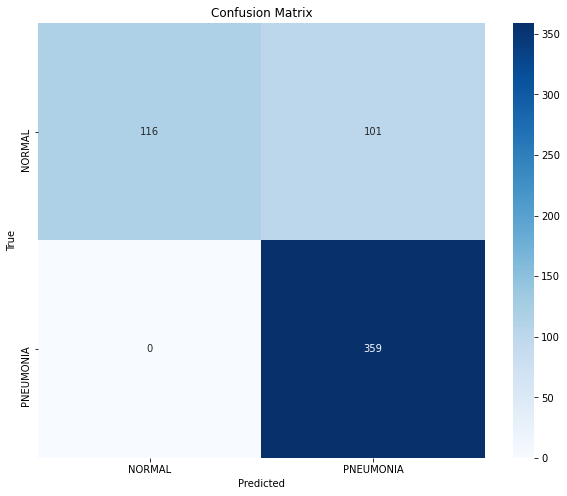

In [21]:
# Afficher la matrice de confusion sous forme de graphique
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.classes, yticklabels=data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")  # Enregistrer la matrice de confusion en image
plt.show()

 <a id="7"></a>
<font color="blue" size=+2.5><b>**Exemple de prédiction sur une image sélectionnée aléatoirement**:</b></font>
<br/>
 
 
>  Pour interpréter les résultats, on utilise un seuil de probabilité pour décider si l'image est classée comme "PNEUMONIA" ou "NORMAL". Généralement, un seuil de 0,5 est utilisé. Cela signifie que si la probabilité associée à "PNEUMONIA" est supérieure à 0,5, l'image est classée comme montrant une pneumonie. Si cette probabilité est inférieure à 0,5, l'image est classée comme normale.

<Figure size 432x432 with 0 Axes>

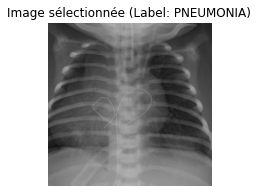

In [22]:
# Sélectionner une image aléatoire à partir de l'ensemble de test
random_idx = random.randint(0, len(test_data.train_ds)-1)
random_img = test_data.train_ds[random_idx][0]  # image
random_label = test_data.train_ds[random_idx][1]  # étiquette réelle

# Afficher l'image sélectionnée avant la prédiction
plt.figure(figsize=(6, 6))
random_img.show(title=f"Image sélectionnée (Label: {random_label})")
plt.axis('off')
plt.show()

# Convertir l'image en un tenseur et l'envoyer au device (GPU ou CPU)
random_img_tensor = random_img.data.to(device).unsqueeze(0)

<Figure size 1152x1152 with 0 Axes>

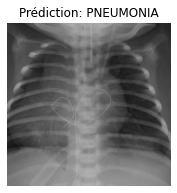

In [24]:
# Faire la prédiction pour l'image aléatoire
with torch.no_grad():
    random_outputs = model(random_img_tensor)
    _, random_pred = torch.max(random_outputs, 1)

# Interprétation des résultats
classes = data.classes  # Liste des classes à partir des données
random_pred_class = classes[random_pred.item()]

# Afficher l'image avec le résultat de la prédiction
plt.figure(figsize=(16, 16))
random_img.show(title=f'Prédiction: {random_pred_class}')
plt.axis('off')
plt.show()

<a href="#top" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>